# Modified EKF and Modified LoFi - Convergence Demo

# 0. Imports and MLP Model

In [1]:
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax.random as jr
from jax import vmap
from jax.lax import scan, dynamic_slice

from rebayes.base import RebayesParams
from rebayes.utils.utils import get_mlp_flattened_params
from rebayes.extended_kalman_filter.ekf import RebayesEKF

In [2]:
# One hidden layer
input_dim, hidden_dims, output_dim = 5, [5], 2
model_dims = [input_dim, *hidden_dims, output_dim]
_, flat_params, _, apply_fn = get_mlp_flattened_params(model_dims)
print(flat_params.shape)

(42,)


# 1. Chaotic Time Series Dataset Generation

The discrete-time Mackey-Glass series is given by the following equation:
$\begin{align} x_{t+1} &= (1-c_1) x_t + c_2 \frac{x_{t-\tau}}{1 + (x_{t-\tau})^{10}} \end{align}
$
for some integer $\tau \geq 1$.

For the training data, we follow the paper "A Recursive Algorithm for Nonlinear Least-Squares Problems" (Alessandri et al.) and choose values $c_1 = 0.1, c_2 = 0.2, \tau = 36$. Also, we assume $x_{i} = 0$ for $i < 0$.

For each series $x_0$ is sampled from a uniform distribution between $0$ and $0.4$.

The first 1,000 time steps are omitted and the successive 500 steps are used for training and the remaining 500 for testing.

In [3]:
def generate_macky_glass(x0, c1=0.1, c2=0.2, tau=36, n_steps=2_000):
    result = [x0]
    for _ in range(tau):
        x_new = (1-c1) * result[-1]
        result.append(x_new)
    
    for _ in range(n_steps-1-tau):
        x_new = (1-c1) * result[-1] + c2 * result[-1-tau]/(1 + result[-1-tau]**10)
        result.append(x_new)
    
    return jnp.array(result)

In [4]:
n_series = 100
key = jr.PRNGKey(0)
x0s = jr.uniform(key, shape=(n_series,), minval=0.0, maxval=0.4)

# Generate 10 Mackay-Glass series
mg_series = vmap(generate_macky_glass)(x0s)

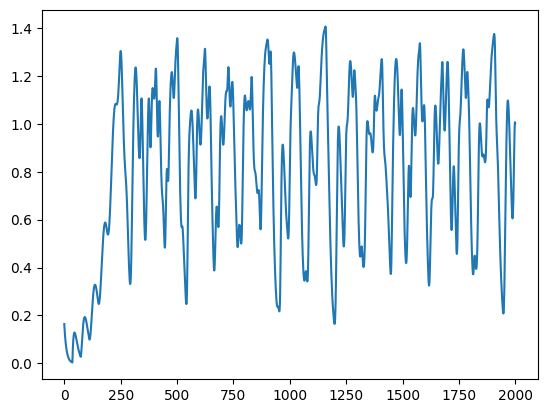

In [5]:
# Plot one of the series as a visual demonstration
plt.plot(mg_series[-1]);

We then transform the time series into $(input, output)$ pairs, where:
$\begin{align} input &= (x_t, x_{t-1}, x_{t-2}, x_{t-3}, x_{t-4}) \\
output &= (x_{t+2}, x_{t+1}) \end{align}$

In [6]:
def extract_input_output(series, n_omit=1_000, n_train=500):
    len_series = len(series)

    def _step(_, i):
        input = dynamic_slice(series, (i-4,), (5,))
        output = dynamic_slice(series, (i+1,), (2,))
        return (input, output), (input, output)
    
    carry = (jnp.arange(5).astype(float), jnp.arange(2).astype(float))
    _, (inputs, outputs) = scan(_step, carry, jnp.arange(n_omit-1, len_series-1))

    X_train, y_train = inputs[:n_train], outputs[:n_train]
    X_test, y_test = inputs[n_train:], outputs[n_train:]

    return (X_train, y_train), (X_test, y_test)

# 2. FC-EKF vs M-FC-EKF

In [7]:
def rmse_callback(bel, *args, **kwargs):
    X_test, y_test = kwargs["X_test"], kwargs["y_test"]
    apply_fn = kwargs["apply_fn"]
    
    yhat = apply_fn(bel.mean, X_test)
    err = jnp.sqrt(((y_test - yhat)**2).mean())
    
    rmse = {
        "test": err,
    }
    return rmse

In [16]:
def compute_average_rmse_over_series(series, key=0, alpha=0.0):
    input_dim, hidden_dims, output_dim = 5, [5], 2
    model_dims = [input_dim, *hidden_dims, output_dim]
    _, flat_params, _, apply_fn = get_mlp_flattened_params(model_dims, key)

    ekf_params = RebayesParams(
        initial_mean=flat_params,
        initial_covariance=1e-2,
        dynamics_weights=1.0,
        dynamics_covariance=1e-2,
        emission_mean_function=apply_fn,
        emission_cov_function=lambda w, x: None,
    )

    ekf_estimator = RebayesEKF(ekf_params, method='fcekf', adaptive_variance=True, alpha=alpha)

    (X_train, y_train), (X_test, y_test) = extract_input_output(series)
    test_kwargs = {"X_test": X_test, "y_test": y_test, "apply_fn": apply_fn}

    _, output = ekf_estimator.scan(X_train, y_train, rmse_callback, **test_kwargs)

    return output['test']

In [60]:
keys = jr.split(jr.PRNGKey(0), 10)
alphas = jnp.array([0.0, 1e-3, 1e-2, 1e-1])
output = vmap(
    vmap(
        vmap(
            compute_average_rmse_over_series, (None, 0, None)
        ), (0, None, None)
    ), (None, None, 0)
)(mg_series, keys, alphas).mean(axis=1)
means, stds = output.mean(axis=1), output.std(axis=1)

  0%|          | 0/500 [00:00<?, ?it/s]

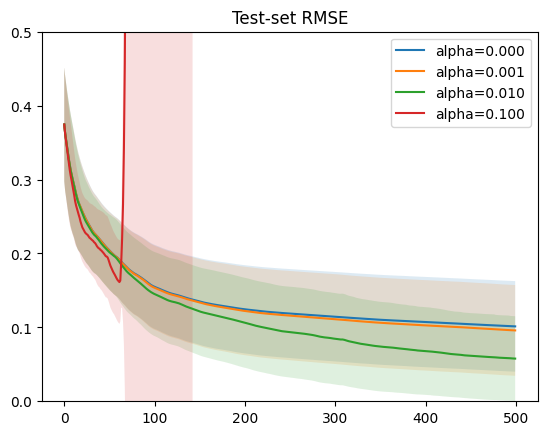

In [61]:
fig, ax = plt.subplots()
for i in range(means.shape[0]):
    ax.plot(means[i], label=f'alpha={alphas[i]:.3f}')
    ax.fill_between(
        jnp.arange(means[i].shape[0]),
        means[i] - 0.5*stds[i],
        means[i] + 0.5*stds[i],
        alpha=0.15
    )
ax.set_ylim(0.0, 0.5)
ax.set_title('FCEKF Test-set RMSE')
ax.legend();